In [ ]:
pip install vaderSentiment

In [ ]:
pip install emosent-py

In [ ]:
pip install emoji

I analyse the performance of various machine learning algorithms and determine the machine that gives the best performance

I use features such as elongated features, emoticon features, pos tag feature, Sentiment140 lexicon feature, unigram/bigram (continuous and non-continuous)

Reading the input twitter data

In [ ]:
import csv
import random
import re
import numpy as np
import pandas as pd
from emosent import get_emoji_sentiment_rank
import emoji
from emoji import UNICODE_EMOJI
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.svm import SVC
from sklearn.metrics import f1_score
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import np_utils
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

data = pd.read_csv("/content/drive/MyDrive/Temp/Constraint_English_Train - Sheet1.csv")
data = data.drop('id', axis=1)
#print(data)
train_X = data.values[:,0]
train_Y = data.values[:,1]
#print(train_X)
#print(train_Y)
dataval = pd.read_csv("/content/drive/MyDrive/Temp/Constraint_English_Val - Sheet1.csv")
dataval = dataval.drop('id', axis=1)
#print(dataval)
val_X = dataval.values[:,0]
val_Y = dataval.values[:,1]

stopwords_set = set(stopwords.words("english"))

Xtrain = []
for s in train_X:
  #print(s)
  r = re.sub(r"http\S+|@\S+", "", s)
  r_lower =r.lower()
  text = TweetTokenizer().tokenize(r_lower)
  sent = ' '.join([w for w in text if w not in stopwords_set])
  Xtrain.append(sent)

Xval = []
for s in val_X:
  #print(s)
  r = re.sub(r"http\S+|@\S+", "", s)
  r_lower =r.lower()
  text = TweetTokenizer().tokenize(r_lower)
  sent = ' '.join([w for w in text if w not in stopwords_set])
  Xval.append(sent)

xtrain=Xtrain
ytrain=train_Y
xval=Xval
yval=val_Y

print(xtrain)
print(ytrain)
print(xval)
print(yval)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['cdc currently reports 99031 deaths . general discrepancies death counts different sources small explicable . death toll stands roughly 100000 people today .', 'states reported 1121 deaths small rise last tuesday . southern states reported 640 deaths .', 'politically correct woman ( almost ) uses pandemic excuse reuse plastic bag #coronavirus #nashville', '#indiafightscorona : 1524 #covid testing laboratories india 25th august 2020 3682752 0 tests done : dg #staysafe #indiawillwin', 'populous states generate large case counts look new cases per million today 9 smaller states showing cases per million california texas : al ar id ks ky la ms nv sc .', 'covid act found " average person illinois covid - 19 infecting 1.11 people . data shows infection growth rate declined time factors stay-at-home order restrictions put place . "', 'tested positive #covid19 symptoms stay h

In [ ]:
for i in range(len(ytrain)):
  #print(ytrain[i])
  if ytrain[i]=='fake':
    ytrain[i]=0
  else:
    ytrain[i]=1
for i in range(len(yval)):
  if yval[i]=='fake':
    yval[i]=0
  else:
    yval[i]=1
#print(ytrain)
#print(yval)

Extract Features

In [ ]:
def get_features(x):
  ''' hashtag feature '''
  hashtag_feature=[]
  for i in range(len(x)):
    curr=x[i]
    cnt=0
    for c in curr:
      if c=='#':
        cnt+=1
    hashtag_feature.append(cnt)

  ''' emoticon feature '''
  f = open("drive/My Drive/9. AFINN-emoticon-8.txt", "r")
  emoticon_score={}
  emoticon_list=[]
  lines=f.readlines()
  for line in lines:
    pair=line.split()
    emoticon_score[pair[0]]=pair[1]
    emoticon_list.append(pair[0])
  '''emoticon_feature = []
  for i in range(len(x)):
    emo_feature=[]
    pos_emoticon_feature=0
    neg_emoticon_feature=0
    curr=x[i]
    flag_pos=0
    flag_neg=0
    for c in curr:
      if c in emoticon_list:
        if int(emoticon_score[c])>=0:
          pos_emoticon_feature=1
          flag_pos=1
        else:
          neg_emoticon_feature=1
          flag_neg=1
      elif c in UNICODE_EMOJI:
        valemoji = get_emoji_sentiment_rank(c)
        if valemoji['positive']>valemoji['negative']:
          pos_emoticon_feature=1
          flag_pos=1
        else:
          neg_emoticon_feature=1
          flag_neg=1
      if flag_pos==1 and flag_neg==1:
          break
    emo_feature.append(pos_emoticon_feature)
    emo_feature.append(neg_emoticon_feature)
    c=curr[len(curr)-1]
    ans=0
    if c in emoticon_list:
      if int(emoticon_score[c])>=0:
        ans=1
      else:
        ans=2
    emo_feature.append(ans)
    emoticon_feature.append(emo_feature)'''
  
  ''' elongated feature '''
  elong_feature = []
  for i in range(len(x)):
      t=x[i]
      countelong=0
      for h in range(len(t)):
          d = t[h]
          c = d[0]
          num = 1
          for m in range(1,len(d)):
              if(num>2):
                  countelong+=1
                  break
              if(d[m]==c):
                  num+=1
              else:
                  c = d[m]
                  num = 1
      elong_feature.append(countelong)

  ''' pos tag feature '''
  pfeature = []
  counttag = 0
  nametag = []
  itag = {}
  for i in range(len(x)):
      currword = x[i]
      # need to check if any need of removing the stop words
      currtag = nltk.pos_tag(currword)
      for j in range(len(currword)):
          wtag = currtag[j][1]
          if(wtag not in nametag):
              nametag.append(wtag)
              itag[wtag] = len(nametag)-1
              counttag+=1
  for k in range(len(x)):
      y = [0]*counttag
      pfeature.append(y)

  for i in range(len(x)):
      currpoint = x[i]
      currptag = nltk.pos_tag(currword)
      for j in range(len(currptag)):
          ptag = currptag[j][1]
          ptagi = itag[ptag]
          pfeature[i][ptagi]+=1
  

  mpqa = open("drive/My Drive/2. mpqa.txt", "r")
  bing_liu = open("drive/My Drive/BingLiu.csv", "r")

  sentiment140_unigram  = open("drive/My Drive/Sentiment140-Lexicon-v0.1/unigrams-pmilexicon.txt", "r")
  sentiment140_bigram  = open("drive/My Drive/Sentiment140-Lexicon-v0.1/bigrams-pmilexicon.txt", "r")
  sentiment140_pairs  = open("drive/My Drive/Sentiment140-Lexicon-v0.1/pairs-pmilexicon.txt", "r")

  NRCemotion  = open("drive/My Drive/NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-v0.92.txt", "r")

  NRChashtag_unigram = open("drive/My Drive/NRC-Hashtag-Sentiment-Lexicon-v0.1/unigrams-pmilexicon.txt", "r") 
  NRChashtag_bigram = open("drive/My Drive/NRC-Hashtag-Sentiment-Lexicon-v0.1/bigrams-pmilexicon.txt", "r")
  NRChashtag_pairs = open("drive/My Drive/NRC-Hashtag-Sentiment-Lexicon-v0.1/pairs-pmilexicon.txt", "r")

  ''' MPQA feature '''

  mpqa_feature = []
  lines=mpqa.readlines()
  mpqa_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]
    emo=pair[1]
    mpqa_dict[tok]=emo
  for i in range(len(x)):
    curr=x[i]
    mpqa_f=[]
    pos_count=0
    neg_count=0
    for j in range(len(x[i])):
      tok=x[i][j]
      if tok in mpqa_dict.keys():
        if mpqa_dict[tok]=='negative':
          neg_count+=1
        elif mpqa_dict[tok]=='positive':
          pos_count+=1
    mpqa_f.append(pos_count)
    total_score=pos_count-neg_count
    max_score=0
    last_pos_score=0
    if pos_count>0:
      max_score=1
      last_pos_score=1
    mpqa_f.append(total_score)
    mpqa_f.append(max_score)
    mpqa_f.append(last_pos_score)
    mpqa_feature.append(mpqa_f)

  ''' Bing Liu '''
  bing_feature=[]
  lines=bing_liu.readlines()
  bing_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]
    emo=pair[1]
    bing_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    bing_f=[]
    pos_count=0
    neg_count=0
    for j in range(len(x[i])):
      tok=x[i][j]
      if tok in bing_dict.keys():
        if bing_dict[tok]=='negative':
          neg_count+=1
        elif bing_dict[tok]=='positive':
          pos_count+=1
    bing_f.append(pos_count)
    total_score=pos_count-neg_count
    max_score=1
    last_pos_score=1
    bing_f.append(total_score)
    bing_f.append(max_score)
    bing_f.append(last_pos_score)
    bing_feature.append(bing_f)

  ''' Sentiment140 lexicon '''
  unigram_sent140_feature = []
  #unigram
  lines=sentiment140_unigram.readlines()
  sent140_unigram_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]
    emo=pair[1]
    sent140_unigram_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    sent140_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])):
      tok=x[i][j]
      if tok in sent140_unigram_dict.keys():
        if float(sent140_unigram_dict[tok])>0:
          pos_count+=1
        total_score+=float(sent140_unigram_dict[tok])
        if max_score<float(sent140_unigram_dict[tok]):
          max_score=float(sent140_unigram_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>=0:
      tok=x[i][j]
      if tok in sent140_unigram_dict.keys():
        if float(sent140_unigram_dict[tok])>=0:
          last_pos_score=float(sent140_unigram_dict[tok])
          break
      j=j-1
    sent140_f=[pos_count,total_score,max_score,last_pos_score]
    unigram_sent140_feature.append(sent140_f)

  #bigram

  bigram_sent140_feature = []
  lines=sentiment140_bigram.readlines()
  sent140_bigram_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]+" "+pair[1]
    emo=pair[2]
    sent140_bigram_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    sent140_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])-1):
      tok=x[i][j]+" "+x[i][j+1]
      if tok in sent140_bigram_dict.keys():
        if float(sent140_bigram_dict[tok])>0:
          pos_count+=1
        total_score+=float(sent140_bigram_dict[tok])
        if max_score<float(sent140_bigram_dict[tok]):
          max_score=float(sent140_bigram_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>0:
      tok=x[i][j-1]+" "+x[i][j]
      if tok in sent140_bigram_dict.keys():
        if float(sent140_bigram_dict[tok])>=0:
          last_pos_score=float(sent140_bigram_dict[tok])
          break
      j=j-1
    sent140_f=[pos_count,total_score,max_score,last_pos_score]
    bigram_sent140_feature.append(sent140_f)

  #non-contiguous

  pairs_sent140_feature = []
  lines=sentiment140_pairs.readlines()
  sent140_pairs_dict={}
  for line in lines:
    pair=line.split()
    tok=""
    ind=0
    for k in range(len(pair)):
      if pair[k].isnumeric():
        ind=k
        break
      else:
        tok+=pair[k]
    emo=pair[ind]
    sent140_pairs_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    sent140_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])-2):
      tok=x[i][j]+"---"+x[i][j+2]
      if tok in sent140_pairs_dict.keys():
        if float(sent140_pairs_dict[tok])>0:
          pos_count+=1
        total_score+=float(sent140_pairs_dict[tok])
        if max_score<float(sent140_pairs_dict[tok]):
          max_score=float(sent140_pairs_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>1:
      tok=x[i][j-2]+"---"+x[i][j]
      if tok in sent140_pairs_dict.keys():
        if float(sent140_pairs_dict[tok])>=0:
          last_pos_score=float(sent140_pairs_dict[tok])
          break
      j=j-1
    sent140_f=[pos_count,total_score,max_score,last_pos_score]
    pairs_sent140_feature.append(sent140_f)

  ''' NRC hashtag lexicon '''
  unigram_nrchashtag_feature = []
  #unigram
  lines=NRChashtag_unigram.readlines()
  nrchashtag_unigram_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]
    emo=pair[1]
    nrchashtag_unigram_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    nrchashtag_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])):
      tok=x[i][j]
      if tok in nrchashtag_unigram_dict.keys():
        if float(nrchashtag_unigram_dict[tok])>0:
          pos_count+=1
        total_score+=float(nrchashtag_unigram_dict[tok])
        if max_score<float(nrchashtag_unigram_dict[tok]):
          max_score=float(nrchashtag_unigram_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>=0:
      tok=x[i][j]
      if tok in nrchashtag_unigram_dict.keys():
        if float(nrchashtag_unigram_dict[tok])>=0:
          last_pos_score=float(nrchashtag_unigram_dict[tok])
          break
      j=j-1
    nrchashtag_f=[pos_count,total_score,max_score,last_pos_score]
    unigram_nrchashtag_feature.append(nrchashtag_f)
  #bigram
  bigram_nrchashtag_feature = []
  lines=NRChashtag_bigram.readlines()
  nrchashtag_bigram_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]+" "+pair[1]
    emo=pair[2]
    nrchashtag_bigram_dict[tok]=emo
  for i in range(len(x)):
    curr=x[i]
    nrchashtag_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])-1):
      tok=x[i][j]+" "+x[i][j+1]
      if tok in nrchashtag_bigram_dict.keys():
        if float(nrchashtag_bigram_dict[tok])>0:
          pos_count+=1
        total_score+=float(nrchashtag_bigram_dict[tok])
        if max_score<float(nrchashtag_bigram_dict[tok]):
          max_score=float(nrchashtag_bigram_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>0:
      tok=x[i][j-1]+" "+x[i][j]
      if tok in nrchashtag_bigram_dict.keys():
        if float(nrchashtag_bigram_dict[tok])>=0:
          last_pos_score=float(nrchashtag_bigram_dict[tok])
          break
      j=j-1
    nrchashtag_f=[pos_count,total_score,max_score,last_pos_score]
    bigram_nrchashtag_feature.append(nrchashtag_f)

  #non-contiguous
  pairs_nrchashtag_feature = []
  lines=NRChashtag_pairs.readlines()
  nrchashtag_pairs_dict={}
  for line in lines:
    pair=line.split()
    tok=""
    ind=0
    for k in range(len(pair)):
      if pair[k].isnumeric():
        ind=k
        break
      else:
        tok+=pair[k]
    emo=pair[ind]
    nrchashtag_pairs_dict[tok]=emo

  for i in range(len(x)):
    curr=x[i]
    nrchashtag_f=[]
    pos_count=0
    total_score=0
    max_score=0
    for j in range(len(x[i])-2):
      tok=x[i][j]+"---"+x[i][j+2]
      if tok in nrchashtag_pairs_dict.keys():
        if float(nrchashtag_pairs_dict[tok])>0:
          pos_count+=1
        total_score+=float(nrchashtag_pairs_dict[tok])
        if max_score<float(nrchashtag_pairs_dict[tok]):
          max_score=float(nrchashtag_pairs_dict[tok])
    j=len(x[i])-1
    last_pos_score=0
    while j>1:
      tok=x[i][j-2]+"---"+x[i][j]
      if tok in nrchashtag_pairs_dict.keys():
        if float(nrchashtag_pairs_dict[tok])>=0:
          last_pos_score=float(nrchashtag_pairs_dict[tok])
          break
      j=j-1
    nrchashtag_f=[pos_count,total_score,max_score,last_pos_score]
    pairs_nrchashtag_feature.append(nrchashtag_f)

  ''' NRC emotion lexicon '''
  nrcemotion_feature = []
  lines=NRCemotion.readlines()
  nrcemotion_dict={}
  for line in lines:
    pair=line.split()
    tok=pair[0]
    emo=pair[2]
    if int(emo)==0:
      if pair[1] in ['anger', 'fear', 'sadness', 'disgust']:
        nrcemotion_dict[tok]=1
      else:
        nrcemotion_dict[tok]=-1
    else:
      if pair[1] in ['anger', 'fear', 'sadness', 'disgust']:
        nrcemotion_dict[tok]=-1
      else:
        nrcemotion_dict[tok]=1
  for i in range(len(x)):
    curr=x[i]
    emo_f=[]
    pos_count=0
    neg_count=0
    for j in range(len(x[i])):
      tok=x[i][j]
      if tok in nrcemotion_dict.keys():
        if nrcemotion_dict[tok]>0:
          pos_count+=1
        else:
          neg_count+=1
    emo_f.append(pos_count)
    total_score=pos_count-neg_count
    max_score=0
    last_pos_score=0
    if pos_count>0:
      max_score=1
      last_pos_score=1
    emo_f.append(total_score)
    emo_f.append(max_score)
    emo_f.append(last_pos_score)
    nrcemotion_feature.append(emo_f)
  
  features=nrcemotion_feature
  ''' Combining all the features '''
  #nrcemotion_feature, pairs_nrchashtag_feature, bigram_nrchashtag_feature, unigram_nrchashtag_feature, pairs_sent140_feature, bigram_sent140_feature, unigram_sent140_feature
  #bing_feature, mpqa_feature, pfeature, elong_feature, emoticon_feature, hashtag_feature
  print(type(nrcemotion_feature[0]), type(pairs_nrchashtag_feature[0]), type(bigram_nrchashtag_feature[0]), type(unigram_nrchashtag_feature[0]), type(pairs_sent140_feature[0]), type(bigram_sent140_feature[0]), type(unigram_sent140_feature[0]))
  print(type(bing_feature[0]), type(mpqa_feature[0]), type(pfeature[0]), type(elong_feature[0]), type(hashtag_feature[0])) #type(emoticon_feature[0])
  for i in range(len(features)):
    features[i]=features[i]+pairs_nrchashtag_feature[i]+bigram_nrchashtag_feature[i]+unigram_nrchashtag_feature[i]+pairs_sent140_feature[i]+bigram_sent140_feature[i]+unigram_sent140_feature[i]+bing_feature[i]+mpqa_feature[i]+pfeature[i]
    features[i].append(elong_feature[i])
    features[i].append(hashtag_feature[i])
  print(features)
  return features
  

In [ ]:
for i in range(len(xtrain)):
  xtrain[i]=xtrain[i].split()

In [ ]:
for i in range(len(xval)):
  xval[i]=xval[i].split()

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
features = get_features(xtrain)
features = np.array(features)
val_features = get_features(xval)
val_features = np.array(val_features)
yt=np.zeros(len(ytrain))
yv=np.zeros(len(yval))
for i in range(len(ytrain)):
  if ytrain[i]==0:
    yt[i]=0
    #yt[i][1]=0
  else:
    yt[i]=1
    #yt[i][0]=0

for i in range(len(yval)):
  if yval[i]==0:
    yv[i]=0
    #yv[i][1]=0
  else:
    yv[i]=1
    #yv[i][0]=0

<class 'list'> <class 'list'> <class 'list'> <class 'list'> <class 'list'> <class 'list'> <class 'list'>
<class 'list'> <class 'list'> <class 'list'> <class 'int'> <class 'int'>
[[1, -7, 1, 1, 0, 0, 0, 0, 0, -2.296, 0, 0, 6, -5.889, 0.478, 0.33, 0, 0, 0, 0, 1, -7.198999999999999, 1.553, 1.553, 7, -4.723999999999999, 0.749, 0.014, 0, -3, 1, 1, 0, -3, 0, 0, 3, 1, 0, 4, 2, 5, 6, 3, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, -4, 0, 0, 0, 0, 0, 0, 1, -0.952, 0.615, 0.615, 6, -2.676, 1.31, 1.171, 0, 0, 0, 0, 1, -4.56, 1.147, 1.147, 4, -5.43, 0.73, 0.483, 0, 0, 1, 1, 0, 0, 0, 0, 3, 1, 0, 4, 2, 5, 6, 3, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -5, 0, 0, 0, 0, 0, 0, 4, -3.557, 0.478, 0.296, 3, -3.9690000000000003, 1.109, 0.255, 0, 0, 0, 0, 4, 3.8019999999999996, 1.658, 0.837, 9, 3.253, 0.896, 0.896, 1, 0, 1, 1, 2, 2, 1, 1, 3, 1, 0, 4, 2, 5, 6, 3, 0, 0, 1, 2, 1,

In [ ]:
print(yt)

[1. 1. 0. ... 0. 0. 1.]


Implementing XGBClassifier using a GridSearch alogirhtm for hyperparameter evaluation

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import GradientBoostingClassifier
model=XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
#Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.30,random_state=42,stratify=y)
grid = GridSearchCV(estimator=model,param_grid=params, cv=5 ,scoring = 'f1') # Turn on cv train scores
grid.fit(features, yt)
print(grid.best_score_)
print(grid.best_estimator_)

0.8069556981459878
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)


Ran Logistic Regression, Gaussian Naive Bayes, KNN, Random Forest Classifier, Adaboost algorithms

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Precision:  0.6386584273511029
Train F1 Score:  0.7269411943473637
Train Accuracy:  0.7200934579439252
Test F1 Score:  0.7388735722725482
Test Accuracy:  0.6901869158878504


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Validation F1 Score:  0.7184931510703185


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Validation Accuracy:  0.7186915887850467
Confusion Matrix
[[539 481]
 [182 938]]
GaussianNB(priors=None, var_smoothing=1e-09)
Precision:  0.5492361560205273
Train F1 Score:  0.14285714285714285
Train Accuracy:  0.502803738317757
Test F1 Score:  0.1650641025641026
Test Accuracy:  0.5130841121495328
Validation F1 Score:  0.4191309509920794
Validation Accuracy:  0.510436137071651
Confusion Matrix
[[ 995   25]
 [1017  103]]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')
Precision:  0.6792294004618771
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.7465277777777778
Test Accuracy:  0.7271028037383177
Validation F1 Score:  0.7311169294507969


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.7322429906542056
Confusion Matrix
[[696 324]
 [260 860]]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Precision:  0.6480083351122785
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.6986977997305792
Test Accuracy:  0.6864485981308411
Validation F1 Score:  0.662393524290614


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.6638629283489097
Confusion Matrix
[[691 329]
 [342 778]]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)
Precision:  0.7215471861032101
Train F1 Score:  1.0
Train Accuracy:  1.0
Test F1 Score:  0.783259911894273
Test Accuracy:  0.7700934579439253
Validation F1 Score:  0.7592409185957305


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.7601246105919003
Confusion Matrix
[[759 261]
 [231 889]]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1)
Precision:  0.7488853650051253
Train F1 Score:  0.8988050219331417
Train Accuracy:  0.8957943925233645
Test F1 Score:  0.8023307933662035
Test Accuracy:  0.7939252336448598
Validation F1 Score:  0.7985358484106868


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.7989096573208723
Confusion Matrix
[[804 216]
 [225 895]]
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
             

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Validation Accuracy:  0.6702492211838006
Confusion Matrix
[[628 392]
 [364 756]]


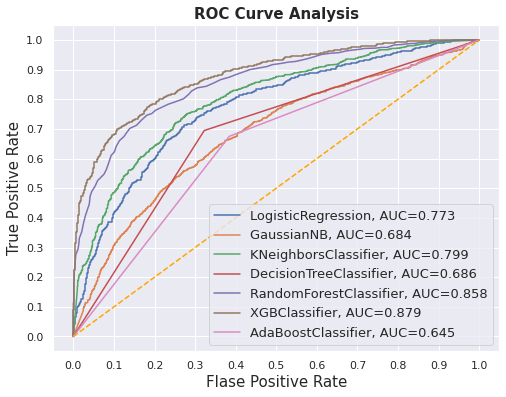

[array([0.7767352 , 0.78624043, 0.77389275, 0.76127508, 0.76165843,
       0.7732099 , 0.77331249, 0.7616552 , 0.77333644, 0.79298392]), array([0.7184543 , 0.67961782, 0.6501337 , 0.63088015, 0.64412784,
       0.62447907, 0.64853095, 0.63246962, 0.68807157, 0.68680577]), array([0.80424573, 0.82324026, 0.81059847, 0.80962977, 0.80001359,
       0.80263452, 0.80689277, 0.80725126, 0.79328357, 0.83122476]), array([0.67104781, 0.66199377, 0.66969226, 0.68644932, 0.67472364,
       0.667562  , 0.67094532, 0.67457181, 0.7138109 , 0.69733572]), array([0.83826604, 0.86433556, 0.84364821, 0.84395738, 0.84355135,
       0.84511031, 0.84147312, 0.85543356, 0.8497721 , 0.87289789]), array([0.87455041, 0.8833377 , 0.87257523, 0.88677377, 0.86848414,
       0.88226266, 0.876437  , 0.86901869, 0.8767311 , 0.88581637]), array([0.63199405, 0.63551402, 0.65652681, 0.67165766, 0.67472364,
       0.65245626, 0.68375214, 0.65076856, 0.67671069, 0.65915799])]


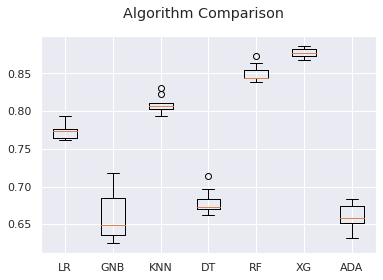

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
'''for i in range(len(ytrain)):
  print(ytrain[i])
  if ytrain[i]=='fake':
    ytrain[i]=0
  else:
    ytrain[i]=1
for i in range(len(yval)):
  if yval[i]=='fake':
    yval[i]=0
  else:
    yval[i]=1
print(ytrain)
print(yval)'''
#yt=np.empty((len(ytrain),1))
#yv=np.empty((len(yval),1))
classifiers = [LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 
               GaussianNB(), 
               KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance'), 
               DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
               RandomForestClassifier(random_state=1234),XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.8, verbosity=1),AdaBoostClassifier(algorithm='SAMME.R',base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,class_weight='balanced',
criterion='gini',max_depth=None,max_features='auto',max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,presort='deprecated',
random_state=11,splitter='best'),learning_rate=1.0, n_estimators=2, random_state=None)] #SVC(gamma ='auto', probability = True)

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
from sklearn.metrics import average_precision_score
seed = 7
# Train the models and record the results
results=[]

for cls in classifiers:
    print(cls)
    #grid = GridSearchCV(estimator=cls, param_grid=dict(alpha=alphas))
    #grid.fit(Xtrain, ytrain)
    #print(grid)
    # summarize the results of the grid search
    #print(grid.best_score_)
    #print(grid.best_estimator_.alpha)
    model = cls.fit(features, yt)
    yproba = model.predict_proba(val_features)[::,1]
    ypred = model.predict(val_features)
    y_trainpred = model.predict(features)
    print("Precision: ",average_precision_score(yv, ypred))
    fpr, tpr, _ = roc_curve(yv,  yproba)
    auc = roc_auc_score(yv, yproba)
    print("Train F1 Score: ", f1_score(yt,y_trainpred))
    print("Train Accuracy: ", accuracy_score(yt, y_trainpred))
    print("Test F1 Score: ", f1_score(yv,ypred))
    print("Test Accuracy: ",accuracy_score(yv, ypred))
    print("Validation F1 Score: ",cross_val_score(cls,features,yt,cv=5,scoring='f1_macro').mean())
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(cls,features,yt,cv=kfold,scoring='roc_auc')
    results.append(cv_results)
    print("Validation Accuracy: ",cross_val_score(cls,features,yt,cv=5,scoring='accuracy').mean())
    print("Confusion Matrix")
    print(confusion_matrix(yv, ypred))
    result_table = result_table.append({'classifiers':cls.__class__.__name__,'fpr':fpr,'tpr':tpr,'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], result_table.loc[i]['tpr'],label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()
print(results)
names=['LR','GNB','KNN','DT','RF','XG','ADA']
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Implemented CNN (Best Result)

In [ ]:
def split_train_val(X_train, op_train):
  samples = list(zip(X_train,op_train))  #combine the representation
  random.seed(13)
  random.shuffle(samples) #random shuffling
  length=len(samples)
  k=int(0.8*length)
  X_train, op_train = zip(*samples[80:220])
  X_test, op_test= zip(*samples[:80])
  return np.array(X_train),np.array(op_train),np.array(X_test),np.array(op_test)
def build_vocab(docs):
    vocab = []
    for doc in docs:
        vocab += doc.split()
    vocab = list(set(vocab))
    w_to_i = {w:i for i,w in enumerate(vocab,1)} #enumerate from 1 to avoid confusion with zero padding
    i_to_w = {i:w for i,w in enumerate(vocab,1)}

    return w_to_i, i_to_w
def one_hot(docs,w_to_i):
    embeddings = []
    for doc in docs:
        embeddings.append([w_to_i[word] for word in doc.split() if word in w_to_i])

    return embeddings
def shuffle_list(*ls):
    l =list(zip(*ls))
    random.shuffle(l)
    return zip(*l)
def predict_operator(X_train, y_train, X_test, y_test,TEST):
    one_hot_dict, inv_one_hot_dict = build_vocab(X_train)
    vocabulary_size = len(one_hot_dict)+1
    X_train_embedding = one_hot(X_train,one_hot_dict)
    X_test_embedding = one_hot(X_test,one_hot_dict)
    TEST_embedding = one_hot(TEST,one_hot_dict)
    category_num = len(set(y_train))
    categories = list(set(y_train))
    o_to_i = {o:i for i,o in enumerate(categories)}
    i_to_o = {i:o for i,o in enumerate(categories)}
    y_train_numeric = []
    y_test_numeric = []
    for label in y_train:
        y_train_numeric.append(o_to_i[label])
    for label in y_test:
        y_test_numeric.append(o_to_i[label])

    y_train_distribution = np_utils.to_categorical(y_train_numeric, category_num)
    y_test_distribution = np_utils.to_categorical(y_test_numeric, category_num)

    # pad documents to max length
    max_length = 100
    X_train_embedding_padded = pad_sequences(X_train_embedding, maxlen=max_length, padding='post')
    X_test_embedding_padded = pad_sequences(X_test_embedding, maxlen=max_length, padding='post')
    TEST_embedding_padded = pad_sequences(TEST_embedding, maxlen=max_length, padding='post')


    X_shuffled, y_shuffled = shuffle_list(X_train_embedding_padded, y_train_distribution)
    length = len(X_shuffled)
    X_train_onehot = np.array(X_shuffled[:int(0.8*length)])
    X_dev_onehot = np.array(X_shuffled[int(0.8*length):])
    #X_TEST_onehot = np.array(X_shuffled[int(0.8*length):])
    y_train_distribution = np.array(y_shuffled[:int(0.8*length)])
    y_dev_distribution = np.array(y_shuffled[int(0.8*length):])
    '''
    embedding_dim = 256
    filter_sizes = [3, 4, 5]
    num_filters = 70
    drop = 0.2

    epochs = 70
    batch_size = 128
    '''
    embedding_dim = 256
    filter_sizes = [3, 4, 5, 6, 7]
    num_filters = 64
    drop = 0.2

    epochs = 10
    batch_size = 128

    print("Creating Model...")
    inputs = Input(shape=(max_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_length)(inputs)
    reshape = Reshape((max_length, embedding_dim, 1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='relu')(reshape)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='relu')(reshape)
    conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[4], embedding_dim), padding='valid', kernel_initializer='normal',
                activation='relu')(reshape)
    

    maxpool_0 = MaxPool2D(pool_size=(max_length - filter_sizes[0] + 1, 1), strides=(1, 1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(max_length - filter_sizes[1] + 1, 1), strides=(1, 1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(max_length - filter_sizes[2] + 1, 1), strides=(1, 1), padding='valid')(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(max_length - filter_sizes[3] + 1, 1), strides=(1, 1), padding='valid')(conv_3)
    maxpool_4 = MaxPool2D(pool_size=(max_length - filter_sizes[4] + 1, 1), strides=(1, 1), padding='valid')(conv_4)
    #maxpool_5 = MaxPool2D(pool_size=(max_length - filter_sizes[5] + 1, 1), strides=(1, 1), padding='valid')(conv_5)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3, maxpool_4])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=category_num, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=output)

    checkpoint = ModelCheckpoint('CNN.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
    adam = Adam(lr=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    #print(model.summary())
    print("Training Model...")
    model.fit(X_train_onehot, y_train_distribution, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[checkpoint],
         validation_data=(X_dev_onehot, y_dev_distribution))

    model.load_weights("CNN.hdf5")
    y_predict = model.predict(X_test_embedding_padded)
    y_predict = [i_to_o[np.argmax(i)] for i in y_predict]

    TEST_preds = model.predict(TEST_embedding_padded)
    TEST_preds = [i_to_o[np.argmax(i)] for i in TEST_preds]
    #print(y_predict)
    print("Operation acc: {}".format(model.evaluate(X_test_embedding_padded,y_test_distribution,verbose=0)[1]))
    #return y_predict
    return TEST_preds

In [ ]:
datatest = pd.read_csv("/content/drive/MyDrive/Temp/Constraint_English_Test - Sheet1.csv")
#datatest = data.drop('id', axis=1)
#print(data)
test_X = datatest.values[:,1]
#print(test_X)
cnn = predict_operator(Xtrain, train_Y, Xval, val_Y, test_X)
print(cnn)
#print("Weighted f1: ",f1_score(val_Y, cnn, average='weighted'))

Creating Model...
Training Model...
Operation acc: 0.9537383317947388
['fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'fake', 'real', '

In [ ]:
opf = open("answer.txt","w")
opf.write("id,label\n")
ids = datatest.values[:,0]
for i in range(len(cnn)):
  opf.write(str(ids[i])+","+cnn[i]+"\n")
  print(str(ids[i])+","+cnn[i]+"\n")
opf.close()